##Omid Jafaei

##Mohammad Jawad Amin

##Mohammad Reza Baqeri

In [1]:
!mkdir /content/Codes
%cd /content/Codes

/content/Codes


# Import libraries

In [2]:
%%capture
!pip install -U transformers
!pip install gdown

In [3]:
from google.colab import files

uploaded = files.upload()

Saving utilityG.py to utilityG.py


In [4]:
from transformers import AutoTokenizer, set_seed, GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import utilityG
import random
import torch
import warnings


warnings.filterwarnings('ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameters

In [6]:
model_name = 'bert-base-uncased'

num_epochs = 4

learning_rate = 3e-4

n_class_dataset = 6

p_dropout = 0.2

batch_size = 64

d_in = 100

d_out = 768

Seed = 42

max_length = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lambda_sup = 1
lambda_feat = 1

# GAN-Bert Model

## Generator_2 (GPT2)

The `Generator_2` class is a network for a  generate noise. It uses the GPT-2 model from the Hugging Face Transformers library for text generation, and a BERT mode..

### Initialization

The class is initialized with a BERT tokenizer, a device (for running the model), and the names of the BERT and GPT-2 models. During initialization, it does the following:

- Loads the GPT-2 tokenizer and model, and resizes the model's token embeddings to match the tokenizer's vocabulary size.
- Moves the model to the specified device.
- Initializes the BERT model.

### Text Noise

The `generate` method generates text given an input prompt. It uses the GPT-2 model's `generate` method, which generates text by sampling from the model's output distribution. The method takes several parameters that control the text generation process, such as the maximum length of the generated text, the number of beams for beam search, the temperature for controlling the randomness of the output, and the top-k and top-p values for top-k sampling and nucleus sampling, respectively.

After generating the text, the method uses a BERT model to process the generated noise.

The method returns the noise.

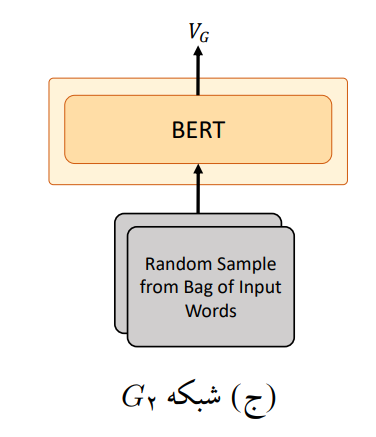

In [7]:
def BERT_Block(text, tokenizer, model, device):

    input = tokenizer(text,
                            return_tensors='pt',
                            truncation=True,
                            padding=True,
                            max_length = max_length).to(device)
    with torch.no_grad():
        output = model(**input, output_hidden_states=True)

    # Extract the last hidden states and the [CLS] token representation
    hidden_states = output.hidden_states[-1]
    CLS = hidden_states[:, 0, :]

    return CLS


In [8]:
class Generator_2:
    def __init__(self, tokenizer_bert, device,model_name_B,model_name_G='gpt2'):


        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name_G)
        self.tokenizer.add_special_tokens({'pad_token': '<PAD>', 'bos_token': '<SOS>', 'eos_token': '<EOS>'})
        self.tokenizer.add_tokens(['<BOT>'])
        self.model = GPT2LMHeadModel.from_pretrained(model_name_G)
        self.model.resize_token_embeddings(len(self.tokenizer))
        for param in self.model.parameters():
            param.requires_grad = False
        self.device = device
        self.model = self.model.to(self.device)
        self.tokenizer_bert = tokenizer_bert
        self.model_bert = utilityG.initialize_model_Bert(model_name_B,device)
        self.BERT_Block = BERT_Block

    def generate(self, input_prompt, max_length=64, num_beams=1, temperature=0.8, do_sample=True, top_k=50, top_p=0.95):

        encoding = self.tokenizer(input_prompt, padding=True, return_tensors='pt').to(self.device)
        output = self.model.generate(
            **encoding,
            max_length=max_length,
            num_beams=num_beams,
            temperature=temperature,
            do_sample=do_sample,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=self.tokenizer.eos_token_id
        )
        text = self.tokenizer.batch_decode(output, skip_special_tokens=True)
        CLS = self.BERT_Block(text, self.tokenizer_bert, self.model_bert, self.device)

        return CLS

## Discriminator

### Input

The `forward` method takes a tensor (`input`) of shape `(batch_size, input_dim)` representing features for evaluation.

### Forward Method

The forward method applies the following operations sequentially:

1. **Dropout Layer 1:**
   - Applies dropout (`p_dropout`) for regularization.

2. **Linear Layer 1:**
   - Fully connected layer transforming the tensor to `d_out` shape.

3. **Leaky ReLU Activation:**
   - Introduces non-linearity with leaky ReLU.

4. **Dropout Layer 2:**
   - Additional dropout for regularization.

5. **Linear Layer 2:**
   - Produces final output for classification.

6. **Softmax Activation:**
   - Computes class probabilities.

### Output

- **\_features:** Output after dropout and first linear layer.
- **logits:** Unnormalized predictions.
- **probs:** Class probabilities.

Designed for binary classification (`1 + n_class_dataset` classes), extendable to multiple classes.


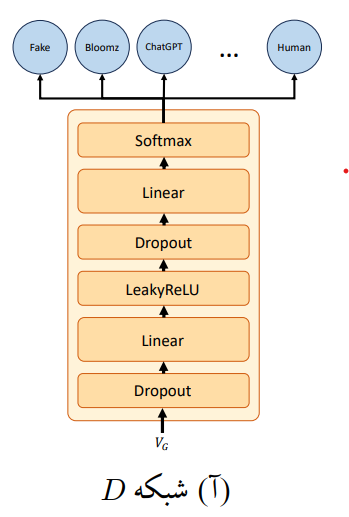

In [9]:
class Discriminator(nn.Module):
    def __init__(self, d_out = d_out, p_dropout = p_dropout, n_class_dataset = n_class_dataset):
        super(Discriminator, self).__init__()

        self.dropout1 = nn.Dropout(p=p_dropout)
        self.linear1 = nn.Linear(d_out, d_out)

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(p=p_dropout)
        self.linear2 = nn.Linear(d_out, 1 + n_class_dataset)

    def forward(self, input):
        features = self.dropout1(input)
        _features = self.linear1(features)

        features = self.leaky_relu(_features)
        features = self.dropout2(features)
        logits = self.linear2(features)

        return  logits,_features

The reason for not using a separate softmax layer is that it is implicitly incorporated in the `nn.CrossEntropyLoss` function in PyTorch.


## Bert Block


# GAN-Bert Model

## Model Initialization

We instantiate a BERT-based tokenizer using the Hugging Face Transformers library and initialize four sets of models and generators for different labeled data percentages (1%, 5%, 10%, and 50%).

Two different loss functions are defined - `nn.BCEWithLogitsLoss` for the generator and discriminator and `nn.CrossEntropyLoss` for calculating the criterion scores.


In [10]:
random.seed(Seed)
np.random.seed(Seed)
torch.manual_seed(Seed)
set_seed(Seed)

tokenizer = AutoTokenizer.from_pretrained(model_name)

modelBERT_OnePercent = utilityG.initialize_model_Bert(model_name, device)
G_OnePercent = Generator_2(tokenizer, device,model_name_B=model_name)
D_OnePercent = Discriminator().to(device)

modelBERT_FivePercent = utilityG.initialize_model_Bert(model_name, device)
G_FivePercent = Generator_2(tokenizer, device,model_name_B=model_name)
D_FivePercent = Discriminator().to(device)

modelBERT_TenPercent = utilityG.initialize_model_Bert(model_name, device)
G_TenPercent = Generator_2(tokenizer,device,model_name_B=model_name)
D_TenPercent = Discriminator().to(device)


modelBERT_FiftyPercent = utilityG.initialize_model_Bert(model_name, device)
G_FiftyPercent = Generator_2(tokenizer, device,model_name_B=model_name)
D_FiftyPercent = Discriminator().to(device)

criterion_G = nn.BCEWithLogitsLoss()
criterion_sup = nn.CrossEntropyLoss()

# Validation Dataset
dataset_val=utilityG.GanBertDataset(Percentage=100, Dataset_Name ='Dev', Seed=42, Download_Dataset = True)
val_loader =  DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


accuracies= []

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Dateset and DataLoader

## Training Model with 1% Labeled Data

In this section, we prepare and visualize 1% of the labeled training and validation data, then train the GAN_BERT classification model.

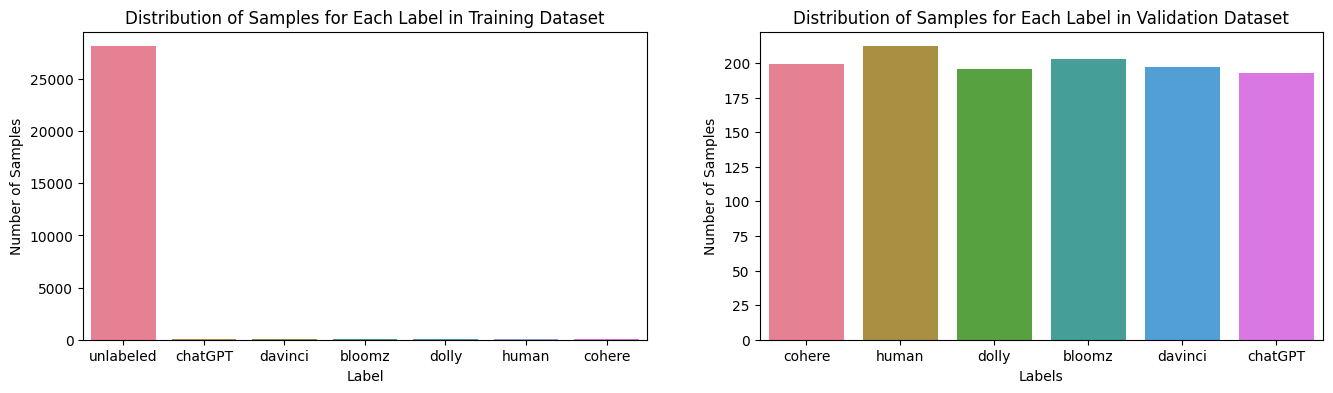


Label Counts for Training Dataset:
unlabeled: 28123
chatGPT: 49
davinci: 44
bloomz: 53
dolly: 51
human: 40
cohere: 50

Label Counts for Validation Dataset:
cohere: 199
human: 212
dolly: 196
bloomz: 203
davinci: 197
chatGPT: 193





In [11]:
dataset_train_Onepercent=utilityG.GanBertDataset(Percentage=1, Dataset_Name ='Train', Seed=42, Download_Dataset = True)
train_loader_Onepercent =  DataLoader(dataset_train_Onepercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Onepercent, dataset_val, 'Part_Three_G2_onePercent_distribution_plot.png')

bert = [i for i in modelBERT_OnePercent.parameters()]
d_vars = bert + [v for v in D_OnePercent.parameters()]

optimizer_D_one = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_one = optim.Adam(G_OnePercent.model_bert.parameters(), lr=learning_rate, betas=(0.9, 0.999))


100%|██████████| 444/444 [12:51<00:00,  1.74s/it]


Epoch 1/4 | G_loss: 0.7134 | D_loss: 1.6333  | Val_Accuracy: 25.17
Best Model saved to Google Drive


100%|██████████| 444/444 [12:28<00:00,  1.69s/it]


Epoch 2/4 | G_loss: 0.7113 | D_loss: 1.5413  | Val_Accuracy: 24.33


100%|██████████| 444/444 [12:25<00:00,  1.68s/it]


Epoch 3/4 | G_loss: 0.7096 | D_loss: 1.4337  | Val_Accuracy: 23.17


100%|██████████| 444/444 [12:20<00:00,  1.67s/it]


Epoch 4/4 | G_loss: 0.7084 | D_loss: 1.3716  | Val_Accuracy: 31.00
Best Model saved to Google Drive


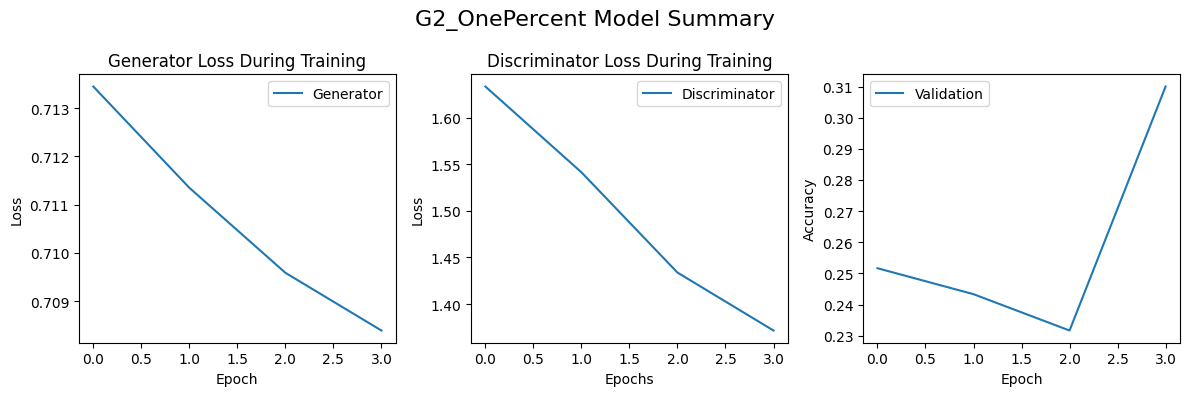

saved Best_Model loaded
Accuracy on Validation dataset is: 31.00


In [12]:
G2_OnePercent = utilityG.model_train(model_Bert = modelBERT_OnePercent,
                               Discriminator = D_OnePercent,
                               Generator = G_OnePercent,
                               kind_G='G2',
                               BERT_Block = BERT_Block,
                               optimizer_D = optimizer_D_one,
                               optimizer_G = optimizer_G_one,
                               criterion_sup = criterion_sup,
                               lambda_sup = lambda_sup,
                               lambda_feat = lambda_feat,
                               criterion_G = criterion_G,
                               tokenizer = tokenizer,
                               train_loader = train_loader_Onepercent,
                               val_loader = val_loader,
                               num_epochs = num_epochs,
                               device = device,
                               d_in = d_in,
                               Name='G2_OnePercent',
                               Use_save_model=False ,save_model= True)
# Train model
G2_OnePercent.train()

# get the accuracy of the model
accuracies.append(G2_OnePercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 5% Labeled Data

In this section, we prepare and visualize 5% of the labeled training and validation data, then train the GAN_BERT classification model.

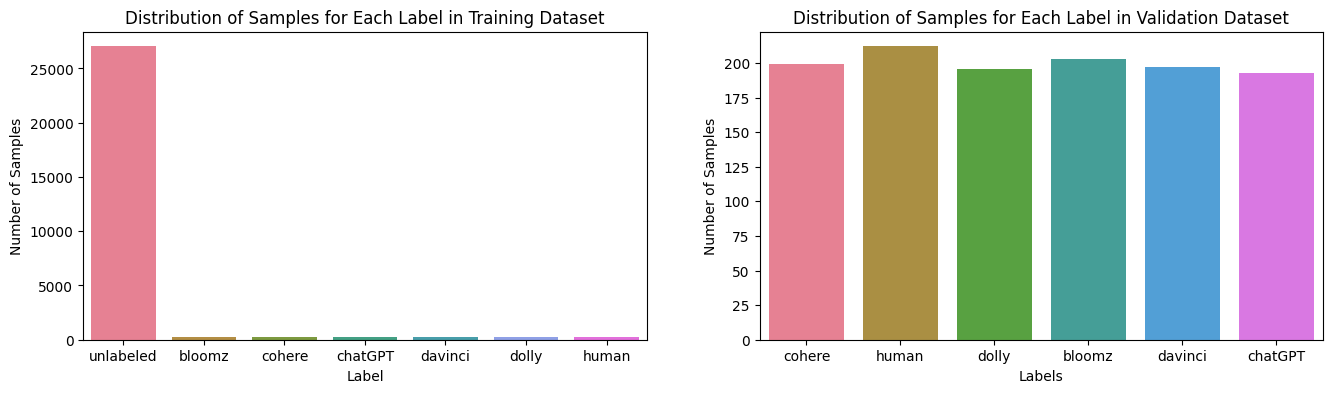


Label Counts for Training Dataset:
unlabeled: 27038
bloomz: 237
cohere: 218
chatGPT: 244
davinci: 233
dolly: 230
human: 210

Label Counts for Validation Dataset:
cohere: 199
human: 212
dolly: 196
bloomz: 203
davinci: 197
chatGPT: 193





In [13]:
dataset_train_Fivepercent=utilityG.GanBertDataset(Percentage=5, Dataset_Name ='Train', Seed=42, Download_Dataset = True)
train_loader_Fivepercent =  DataLoader(dataset_train_Fivepercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Fivepercent, dataset_val, 'Part_Three_G2_FivePercent_distribution_plot.png')

bert = [i for i in modelBERT_FivePercent.parameters()]
d_vars = bert + [v for v in D_FivePercent.parameters()]
optimizer_D_5 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_5 = optim.Adam(G_FivePercent.model_bert.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 444/444 [11:26<00:00,  1.55s/it]


Epoch 1/4 | G_loss: 0.7143 | D_loss: 2.4529  | Val_Accuracy: 33.00
Best Model saved to Google Drive


100%|██████████| 444/444 [11:31<00:00,  1.56s/it]


Epoch 2/4 | G_loss: 0.7151 | D_loss: 2.2787  | Val_Accuracy: 37.50
Best Model saved to Google Drive


100%|██████████| 444/444 [11:27<00:00,  1.55s/it]


Epoch 3/4 | G_loss: 0.7120 | D_loss: 2.1514  | Val_Accuracy: 36.50


100%|██████████| 444/444 [11:22<00:00,  1.54s/it]


Epoch 4/4 | G_loss: 0.7105 | D_loss: 2.1182  | Val_Accuracy: 36.92


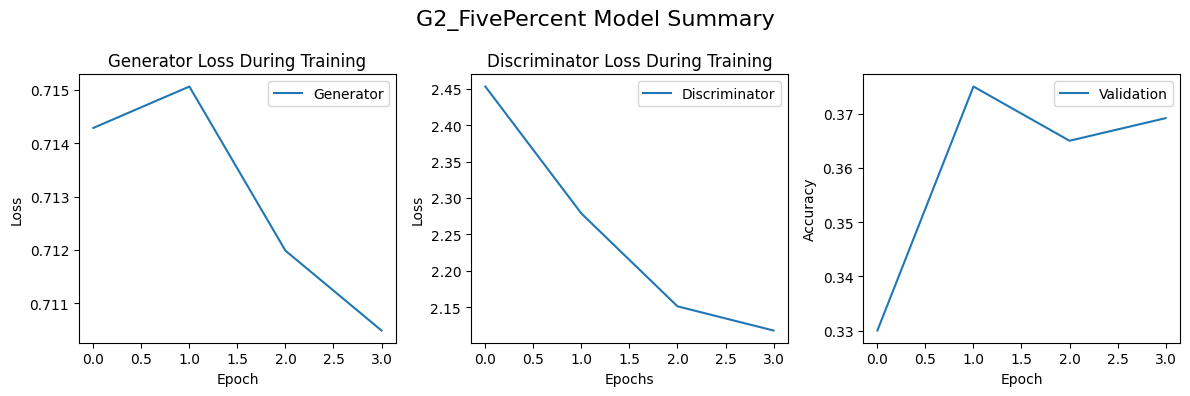

saved Best_Model loaded
Accuracy on Validation dataset is: 37.50


In [14]:
G2_FivePercent = utilityG.model_train(model_Bert = modelBERT_FivePercent,
                                 Discriminator = D_FivePercent,
                                 Generator = G_FivePercent,
                                kind_G='G2',
                                 BERT_Block = BERT_Block,
                                 optimizer_D = optimizer_D_5,
                                 optimizer_G = optimizer_G_5,
                                 criterion_sup = criterion_sup,
                                 lambda_sup = lambda_sup,
                                 lambda_feat = lambda_feat,
                                 criterion_G = criterion_G,
                                 tokenizer = tokenizer,
                                 train_loader = train_loader_Fivepercent,
                                 val_loader = val_loader,
                                 num_epochs =num_epochs,
                                 device = device,
                                 d_in = d_in,
                                 Name='G2_FivePercent',
                                 Use_save_model=False ,save_model= True)
# Train model
G2_FivePercent.train()

# get the accuracy of the model
accuracies.append(G2_FivePercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 10% Labeled Data

In this section, we prepare and visualize 10% of the labeled training and validation data, then train the GAN_BERT classification model.

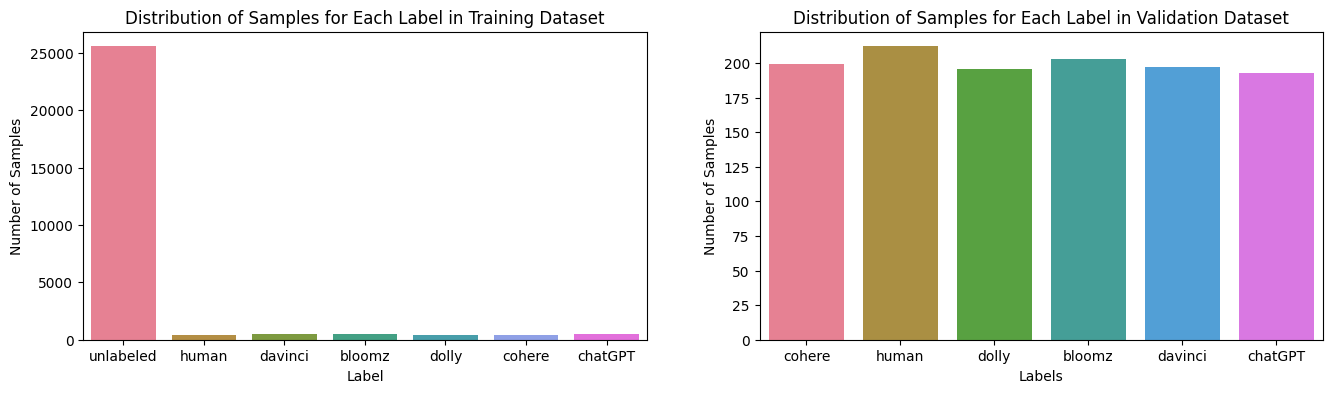


Label Counts for Training Dataset:
unlabeled: 25578
human: 450
davinci: 484
bloomz: 513
dolly: 452
cohere: 451
chatGPT: 482

Label Counts for Validation Dataset:
cohere: 199
human: 212
dolly: 196
bloomz: 203
davinci: 197
chatGPT: 193





In [18]:
dataset_train_Tenpercent=utilityG.GanBertDataset(Percentage=10, Dataset_Name ='Train', Seed=42, Download_Dataset = True)
train_loader_Tenpercent =  DataLoader(dataset_train_Tenpercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Tenpercent, dataset_val, 'Part_Three_G2_TenPercent_distribution_plot.png')

bert = [i for i in modelBERT_TenPercent.parameters()]
d_vars = bert + [v for v in D_TenPercent.parameters()]
optimizer_D_10 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_10 = optim.Adam(G_TenPercent.model_bert.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 444/444 [11:17<00:00,  1.53s/it]


Epoch 1/4 | G_loss: 0.7157 | D_loss: 2.2168  | Val_Accuracy: 38.08
Best Model saved to Google Drive


100%|██████████| 444/444 [11:41<00:00,  1.58s/it]


Epoch 2/4 | G_loss: 0.7104 | D_loss: 2.2215  | Val_Accuracy: 39.17
Best Model saved to Google Drive


100%|██████████| 444/444 [11:15<00:00,  1.52s/it]


Epoch 3/4 | G_loss: 0.7078 | D_loss: 2.1504  | Val_Accuracy: 40.58
Best Model saved to Google Drive


100%|██████████| 444/444 [11:09<00:00,  1.51s/it]


Epoch 4/4 | G_loss: 0.7065 | D_loss: 2.1031  | Val_Accuracy: 43.08
Best Model saved to Google Drive


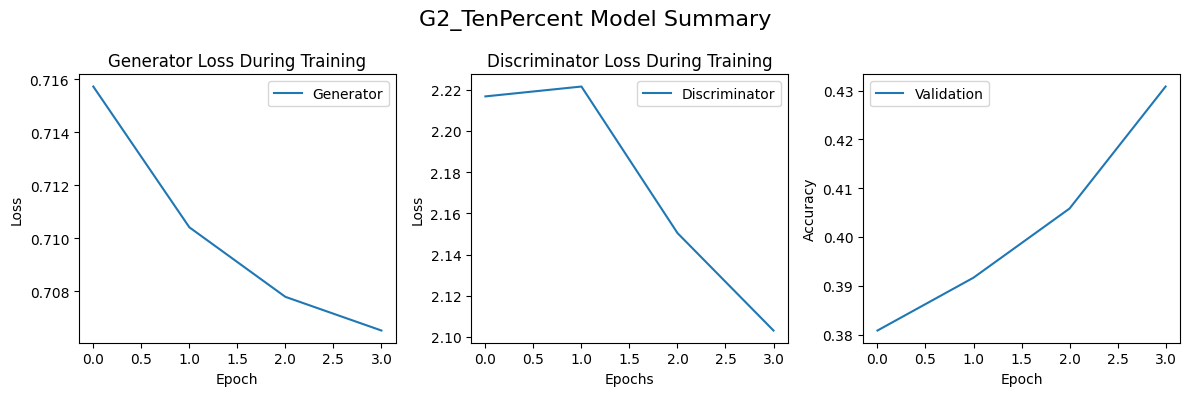

saved Best_Model loaded
Accuracy on Validation dataset is: 43.08


In [19]:
G2_TenPercent = utilityG.model_train(model_Bert = modelBERT_TenPercent,
                                    Discriminator = D_TenPercent,
                                    Generator = G_TenPercent,
                                    kind_G='G2',
                                    BERT_Block = BERT_Block,
                                    optimizer_D = optimizer_D_10,
                                    optimizer_G = optimizer_G_10,
                                    criterion_sup = criterion_sup,
                                    lambda_sup = lambda_sup,
                                    lambda_feat = lambda_feat,
                                    criterion_G = criterion_G,
                                    tokenizer = tokenizer,
                                    train_loader = train_loader_Tenpercent,
                                    val_loader = val_loader,
                                    num_epochs =num_epochs,
                                    device = device,
                                    d_in = d_in,
                                    Name='G2_TenPercent',
                                    Use_save_model=False ,save_model= True)
# Train model
G2_TenPercent.train()

# get the accuracy of the model
accuracies.append(G2_TenPercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 50% Labeled Data

In this section, we prepare and visualize 50% of the labeled training and validation data, then train the GAN_BERT classification model.

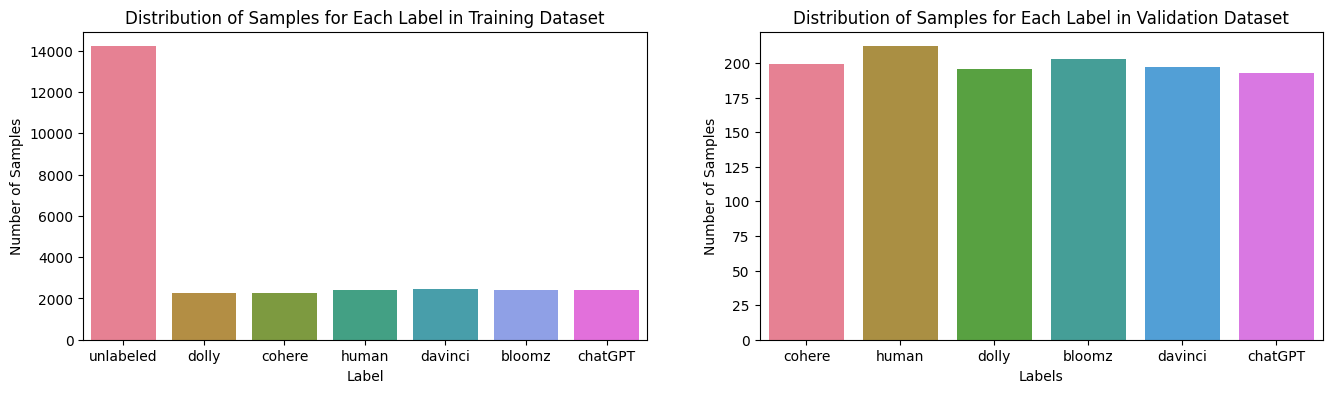


Label Counts for Training Dataset:
unlabeled: 14208
dolly: 2285
cohere: 2264
human: 2387
davinci: 2435
bloomz: 2422
chatGPT: 2409

Label Counts for Validation Dataset:
cohere: 199
human: 212
dolly: 196
bloomz: 203
davinci: 197
chatGPT: 193





In [20]:
dataset_train_Fiftypercent=utilityG.GanBertDataset(Percentage=50, Dataset_Name ='Train', Seed=42, Download_Dataset = True)
train_loader_Fiftypercent =  DataLoader(dataset_train_Fiftypercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Fiftypercent, dataset_val, 'Part_Three_G2_FiftyPercent_distribution_plot.png')

bert = [i for i in modelBERT_FiftyPercent.parameters()]
d_vars = bert + [v for v in D_FiftyPercent.parameters()]
optimizer_D_50 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_50 = optim.Adam(G_FiftyPercent.model_bert.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 444/444 [13:03<00:00,  1.76s/it]


Epoch 1/4 | G_loss: 0.7129 | D_loss: 2.3298  | Val_Accuracy: 42.00
Best Model saved to Google Drive


100%|██████████| 444/444 [13:08<00:00,  1.77s/it]


Epoch 2/4 | G_loss: 0.7073 | D_loss: 2.1530  | Val_Accuracy: 45.58
Best Model saved to Google Drive


100%|██████████| 444/444 [13:05<00:00,  1.77s/it]


Epoch 3/4 | G_loss: 0.7038 | D_loss: 2.1009  | Val_Accuracy: 47.17
Best Model saved to Google Drive


100%|██████████| 444/444 [13:02<00:00,  1.76s/it]


Epoch 4/4 | G_loss: 0.7033 | D_loss: 2.0632  | Val_Accuracy: 50.33
Best Model saved to Google Drive


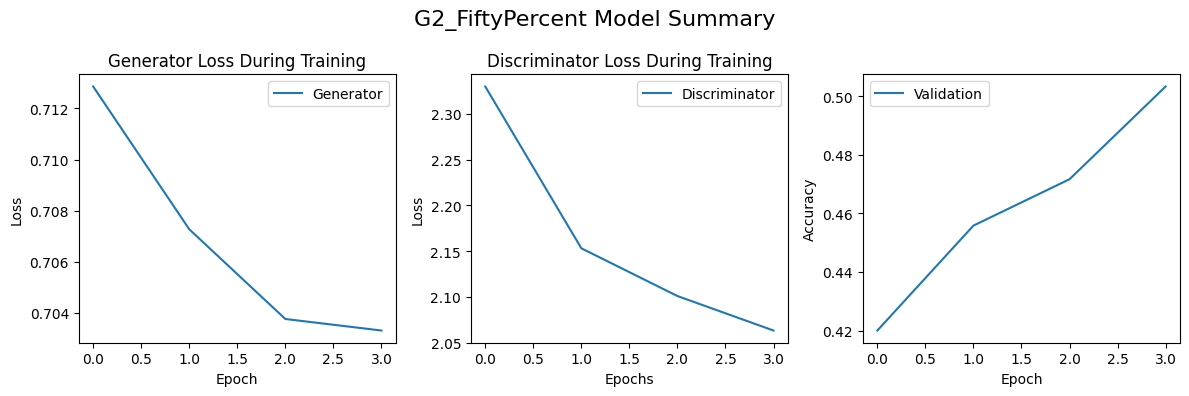

saved Best_Model loaded
Accuracy on Validation dataset is: 50.33


In [21]:
G2_FiftyPercent = utilityG.model_train(model_Bert = modelBERT_FiftyPercent,
                                        Discriminator = D_FiftyPercent,
                                        Generator = G_FiftyPercent,
                                        kind_G='G2',
                                        BERT_Block = BERT_Block,
                                        optimizer_D = optimizer_D_50,
                                        optimizer_G = optimizer_G_50,
                                        criterion_sup = criterion_sup,
                                        lambda_sup = lambda_sup,
                                        lambda_feat = lambda_feat,
                                        criterion_G = criterion_G,
                                        tokenizer = tokenizer,
                                        train_loader = train_loader_Fiftypercent,
                                        val_loader = val_loader,
                                        num_epochs =num_epochs,
                                        device = device,
                                        d_in = d_in,
                                        Name='G2_FiftyPercent',
                                        Use_save_model=False ,save_model= True)
# Train model
G2_FiftyPercent.train()

# get the accuracy of the model
accuracies.append(G2_FiftyPercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Plotting Accuracy vs. Percentage of Labeled Data

In this section, we visualize the accuracy of the BERT-based sequence classification model at different percentages of labeled data.


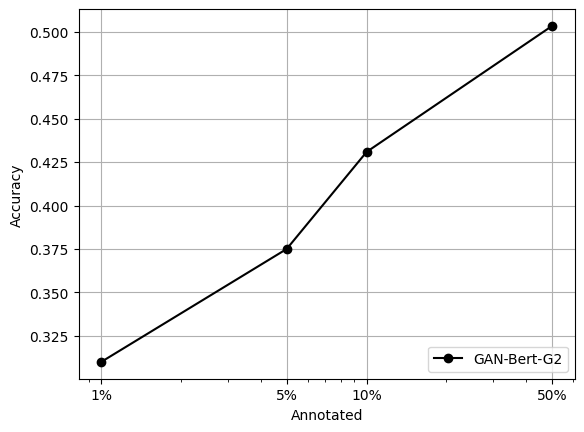

In [24]:
percentages = [1, 5, 10, 50]

utilityG.plot_accuracy_vs_percentage(percentages, accuracies, label='GAN-Bert-G2')

In [25]:
from google.colab import files

uploaded = files.upload()

Saving bert_accuracies.pkl to bert_accuracies.pkl


In [26]:
import pickle

with open('bert_accuracies.pkl', 'rb') as file:
    bert_accuracies = pickle.load(file)

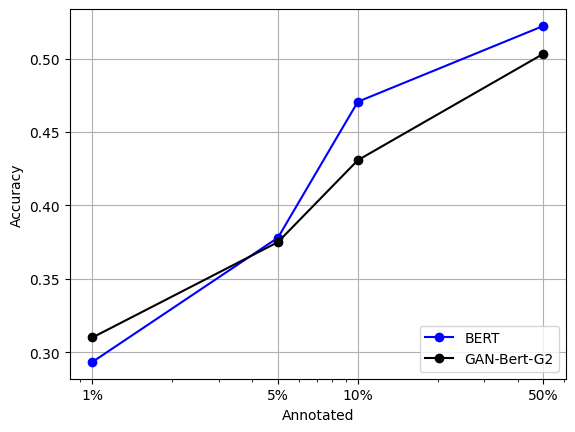

In [32]:
import matplotlib.pyplot as plt
plt.semilogx(percentages, bert_accuracies, marker='o', color='blue', label='BERT')
plt.semilogx(percentages, accuracies, marker='o', color='black', label='GAN-Bert-G2')
plt.xticks(percentages, [f"{p}%" for p in percentages])

plt.xlabel('Annotated')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('../Plots/compare-G2.png')
plt.show()

In [28]:
with open('G2_accuracies.pkl', 'wb') as file:
    pickle.dump(accuracies, file)

In [29]:
from google.colab import files

uploaded = files.upload()

Saving G1_accuracies.pkl to G1_accuracies.pkl


In [30]:
with open('G1_accuracies.pkl', 'rb') as file:
    G1_accuracies = pickle.load(file)

In [ ]:
plt.semilogx(percentages, bert_accuracies, marker='o', color='blue', label='BERT')
plt.semilogx(percentages, accuracies, marker='o', color='black', label='GAN-Bert-G2')
plt.semilogx(percentages, G1_accuracies, marker='o', color='red', label='GAN-Bert-G1')
plt.xticks(percentages, [f"{p}%" for p in percentages])

plt.xlabel('Annotated')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('../Plots/compare-G2-G1.png')
plt.show()

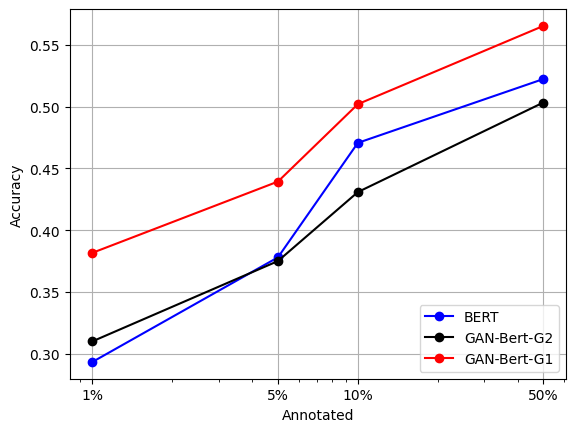